In [11]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git >> /tmp/null
!pip install roboflow >> /tmp/null


  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git /tmp/pip-req-build-p_9dpa1v


In [22]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


import random
import warnings
import cv2

from functools import partial
from enum import auto, Enum

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.manifold import TSNE

from gcpds.image_segmentation.datasets.segmentation import OxfordIiitPet
from gcpds.image_segmentation.visualizations import plot_contour
from gcpds.image_segmentation.models import unet_baseline
# from gcpds.image_segmentation.losses import DiceCoefficient
import tensorflow.keras.backend as K


from matplotlib.style import available
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.python.framework.ops import EagerTensor

import matplotlib.pyplot as plt
import os
import numpy as np

import time

from roboflow import Roboflow

import gdown




## Fetch pre trained UNet model

In [75]:
model_folder_id = "1QnV6GLaH6ciuyqsgNHKIqTi2JwsAlWbE"


gdown.download_folder(id=model_folder_id)

Retrieving folder contents


Processing file 1n2bttENgwvJdJyZSaiIGO5RFoVg7UyVY tomato_seed_base_model.keras
Building directory structure completed


Retrieving folder contents completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1n2bttENgwvJdJyZSaiIGO5RFoVg7UyVY
To: /content/Tomado Seeds/tomato_seed_base_model.keras
100%|██████████| 6.16M/6.16M [00:00<00:00, 113MB/s]
Download completed


['/content/Tomado Seeds/tomato_seed_base_model.keras']

## Fetch dataset

In [18]:
rf = Roboflow(api_key="3ioUIbqERJ2jEWElELQN")
project = rf.workspace("gcpds-tm2ae").project("seed-detection-2")
dataset = project.version(1).download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...


In [73]:
def decode_img(img, target_size):
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, target_size) / 255.0

def decode_mask(mask, target_size):
    mask = tf.image.decode_png(mask, channels=1)
    return tf.image.resize(mask, target_size) / 255.0

def process_path(image_path, mask_path, target_size):
    img = tf.io.read_file(image_path)
    img = decode_img(img, target_size)
    mask = tf.io.read_file(mask_path)
    mask = decode_mask(mask, target_size)
    return img, mask

def load_dataset(data_dir, target_size):
    image_files = [f for f in os.listdir(data_dir) if f.endswith(".jpg")]
    image_paths = [os.path.join(data_dir, img_file) for img_file in image_files]
    mask_paths = [path.replace(".jpg", "_mask.png") for path in image_paths]

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda x, y: process_path(x, y, target_size),
                          num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset


## Loading dataset

In [74]:
train_dataset = load_dataset(data_dir="./Seed-Detection-2-1/train", target_size=(256,256) )
test_dataset = load_dataset(data_dir="./Seed-Detection-2-1/test", target_size=(256,256)  )
val_dataset = load_dataset(data_dir="./Seed-Detection-2-1/valid", target_size=(256,256)  )

In [76]:
model_extension = "keras"
folder_name = "/content/Tomado Seeds"
paths = []

for file in os.listdir(folder_name):
  if file.endswith(model_extension):
    paths.append(file)

model_path = os.path.join(folder_name, paths[0])
print(f"Loading {model_path}...")
model  = tf.keras.models.load_model(model_path, compile = False)

Loading /content/Tomado Seeds/tomato_seed_base_model.keras...


In [77]:
model.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>

In [78]:
def find_last_encoder_conv_layer(model):
  last_conv_encoder_layer = 0
  for i,layer in enumerate(model.layers):
    if (isinstance(layer, keras.layers.Conv2D)):
      last_conv_encoder_layer = i
    if (isinstance(layer, keras.layers.UpSampling2D)):
      break
  return last_conv_encoder_layer

last_conv_encoder_layer = find_last_encoder_conv_layer(model)
last_conv_encoder_layer

24

In [79]:
def compute_snr(signal:float, noise_std:float)->float:
  return  10 * np.log10(np.mean(signal ** 2)  / noise_std ** 2)

class SnrType(Enum):
  log = 0
  linear = 1


def add_noise_to_layer_weights(model, layer, noise_snr, snr_type: SnrType = SnrType.log, verbose = 0):
  layer_weights = model.layers[layer].get_weights()

  sig_power = np.mean(layer_weights[0] ** 2)


  if snr_type == SnrType.log:
    noise_power = sig_power / (10 ** (noise_snr / 10) )
  elif snr_type == SnrType.linear:
    noise_power = sig_power / noise_snr

  noise_std = noise_power ** ( 1 / 2)

  snr = compute_snr(layer_weights[0], noise_std)


  if verbose > 0 :
    print(f"Adding noise for snr: {noise_snr}\n\n")
    print(f"Signal power: {sig_power}")
    print(f"Noise power: {noise_power}\n\n")

  for i in range(layer_weights[0].shape[0]):
    for j in range(layer_weights[0].shape[1]):
      layer_weights[0][i][j] += np.random.randn(128,128) * noise_std

  model.layers[last_conv_encoder_layer].set_weights(layer_weights)
  return snr

In [113]:
values_to_test = [10, 5, 2, 0, -10]


def produce_disturbed_models(values_to_test, base_model_path):
  snr_values = []
  models = []

  for value in values_to_test:
    model_ = tf.keras.models.load_model(base_model_path, compile = False)
    snr = add_noise_to_layer_weights(model_, last_conv_encoder_layer, value)
    snr_values.append(snr)
    models.append(model_)
  return models, snr_values

disturbance_models, snr_values = produce_disturbed_models(values_to_test, model_path)

In [114]:
disturbance_models[0].output

<KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'Conv100')>

In [115]:
BATCH_SIZE = 16
TARGET_SHAPE = 256, 256
ANNOTATORS = 5

def disturb_mask(model, image):
  return model(image)



def mix_channels(mask, num_annotators):
  return tf.stack([mask, 1-mask], axis=-2)

def add_noisy_annotators(img: EagerTensor, models)->EagerTensor:
  return [disturb_mask(model, img) for model in models]



def map_dataset_MA(dataset, target_shape, batch_size, num_annotators):

    dataset_ = dataset.map(lambda img,mask: (tf.image.resize(img,target_shape), tf.image.resize(mask,target_shape)),
                                    num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img,mask: (tf.image.resize(img,target_shape), tf.image.resize(mask,target_shape)),
                                    num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img,mask: (img, add_noisy_annotators(tf.expand_dims(img, 0), disturbance_models)),
                           num_parallel_calls=tf.data.AUTOTUNE)

    #transpose dataset

    dataset_ = dataset_.map(lambda img,mask: (img, tf.squeeze(mask, axis=-1)),
                           num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img,mask: (img, tf.transpose(mask, [2,3,1,0])),
                           num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.batch(batch_size)
    return dataset_


train = map_dataset_MA(train_dataset, TARGET_SHAPE, BATCH_SIZE, ANNOTATORS)
val = map_dataset_MA(val_dataset, TARGET_SHAPE, BATCH_SIZE, ANNOTATORS)
test = map_dataset_MA(test_dataset, TARGET_SHAPE, BATCH_SIZE, ANNOTATORS)

Mask shape: (16, 256, 256, 1, 5) (batch_size * h * w * k * r)


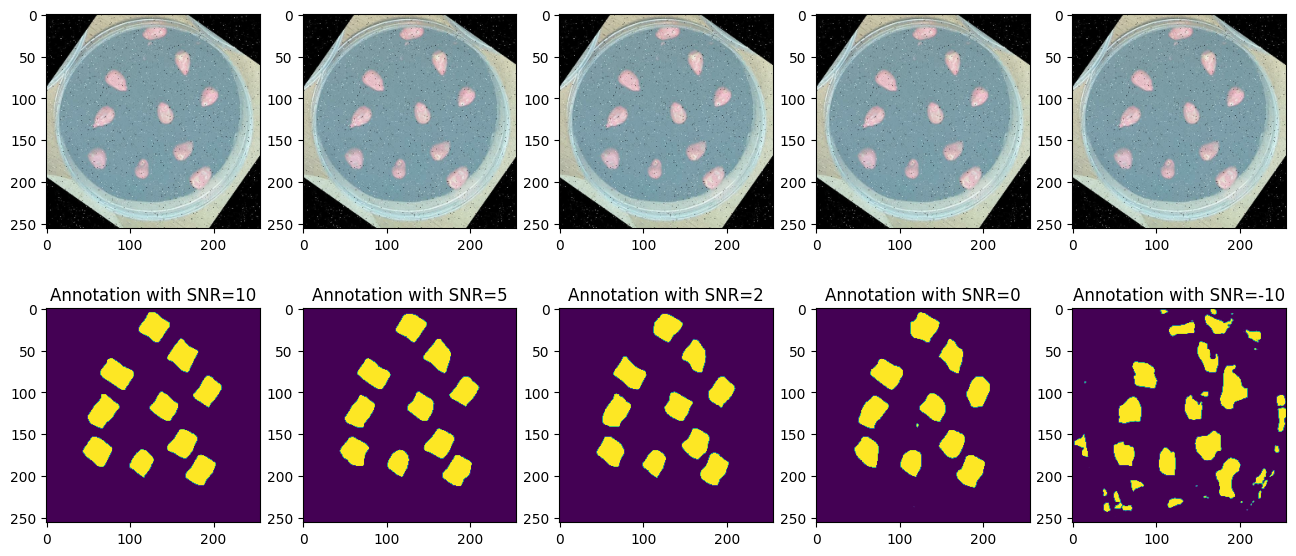

In [118]:
for img,mask in train.take(1):
  print(f"Mask shape: {mask.shape} (batch_size * h * w * k * r)")
  fig, axes = plt.subplots(2,ANNOTATORS)
  fig.set_size_inches(16,7)
  for i in range(ANNOTATORS):
    axes[0][i].imshow(img[0])
    axes[1][i].imshow(mask[0,:,:,0,i])
    axes[1][i].set_title(f"Annotation with SNR={values_to_test[i]}")